<a href="https://colab.research.google.com/github/Nafishsy/ResNet-for-Chest-Xray/blob/main/Covid19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data load from kaggle

In [1]:
!pip install -q kaggle

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [3]:
!chmod 600 /root/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [4]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database --force

Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
License(s): copyright-authors
100% 777M/778M [00:45<00:00, 18.4MB/s]
100% 778M/778M [00:45<00:00, 17.9MB/s]


# # Run this again if you changed directory files, other than that quite ram hungry and time consuming

In [5]:
!unzip -o "/content/covid19-radiography-database.zip" -d '/content/dataset'


Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/COVID-19_Radiography_Dataset/Normal/masks/Normal-7921.png  
  inflating: /content/dataset/COVID-19_Radiography_Dataset/Normal/masks/Normal-7922.png  
  inflating: /content/dataset/COVID-19_Radiography_Dataset/Normal/masks/Normal-7923.png  
  inflating: /content/dataset/COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: /content/dataset/COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: /content/dataset/COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: /content/dataset/COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: /content/dataset/COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: /content/dataset/COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: /content/dataset/COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: /content/dataset/COVID-19_Radiography

In [6]:
import os
import pandas as pd
import numpy as np
from glob import glob
import torch
from PIL import Image
from skimage import io, transform
from skimage.util import random_noise
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import time
from datetime import datetime
import gc
import tensorflow as tf


# **Data Prep**





In [7]:
data_dir = '/content/dataset/COVID-19_Radiography_Dataset'
covid_files_before = os.listdir(data_dir+'/COVID/images')
normal_files_before = os.listdir(data_dir+'/Normal/images')
pneumonia_files_before = os.listdir(data_dir+'/Viral Pneumonia/images')

print('Number of COVID scans before undersampling:',len(covid_files_before))
print('Number of Normal scans before undersampling:',len(normal_files_before))
# print('Number of Pneumonia scans before undersampling:',len(pneumonia_files_before))
print('Number of COVID scans + Normal scans:',len(covid_files_before)+len(normal_files_before))

Number of COVID scans before undersampling: 3616
Number of Normal scans before undersampling: 10192
Number of COVID scans + Normal scans: 13808


In [8]:
data_dir = '/content/dataset/COVID-19_Radiography_Dataset'

def load_image_class(image_path, image_size=(256, 256)):
    # Load the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, image_size)
    image = image / 255.0  # Normalize to [0, 1]

    # Extract the class name from the file path
    class_name = tf.strings.split(image_path, os.path.sep)[-3]

    # Convert class name to a numerical label (e.g., 'COVID' = 1, 'Normal' = 0)
    label = tf.where(class_name == 'COVID', 1, 0)

    return image, label

# Function to retrieve the dataset of images and class names
def load_dataset(data_dir, image_size=(256, 256), batch_size=16):
    # Create a list for images
    image_paths = []

    # Iterate over classes
    for class_name in ['COVID', 'Normal']:
        # Add file paths for the images in the class folder
        class_images = glob(os.path.join(data_dir, class_name, 'images', '*.png'))
        image_paths.extend(class_images)

    # Create a TensorFlow dataset from image paths
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)

    # Map the loading function to the dataset
    dataset = dataset.map(lambda image_path: load_image_class(image_path, image_size),
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Batch the dataset
    dataset = dataset.batch(batch_size)

    return dataset

# Load the dataset
main_dataset = load_dataset(data_dir)

In [9]:
def split_dataset(dataset, train_size=0.7, val_size=0.15):
    dataset_size = tf.data.experimental.cardinality(dataset).numpy()  # Get the total dataset size
    train_size = int(train_size * dataset_size)
    val_size = int(val_size * dataset_size)

    # Split the dataset into training, validation, and test sets
    train_dataset = dataset.take(train_size)
    remaining_dataset = dataset.skip(train_size)
    val_dataset = remaining_dataset.take(val_size)
    test_dataset = remaining_dataset.skip(val_size)

    return train_dataset, val_dataset, test_dataset


In [10]:
# Split into train, validation, and test sets
train_dataset, val_dataset, test_dataset = split_dataset(main_dataset)

# Print sizes of the datasets
print(f"Training samples: {tf.data.experimental.cardinality(train_dataset).numpy()}")
print(f"Validation samples: {tf.data.experimental.cardinality(val_dataset).numpy()}")
print(f"Test samples: {tf.data.experimental.cardinality(test_dataset).numpy()}")


Training samples: 604
Validation samples: 129
Test samples: 130


In [11]:
for images, labels in main_dataset.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
    print("Labels:", labels.numpy())

Image batch shape: (16, 256, 256, 3)
Label batch shape: (16,)
Labels: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


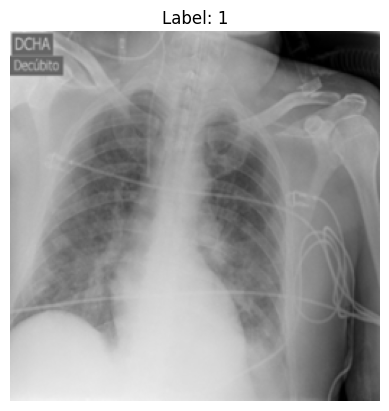

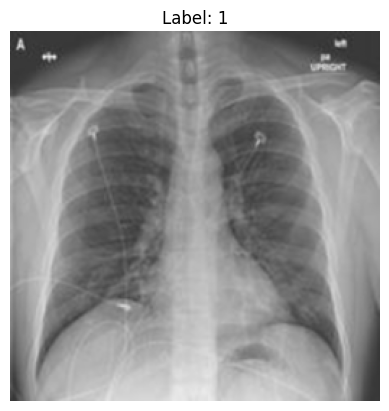

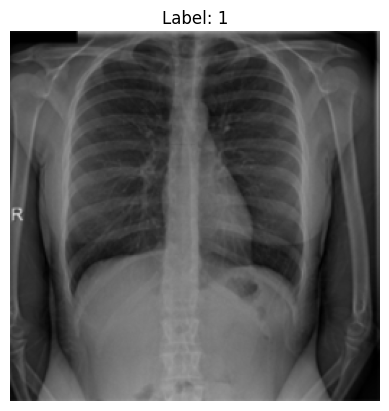

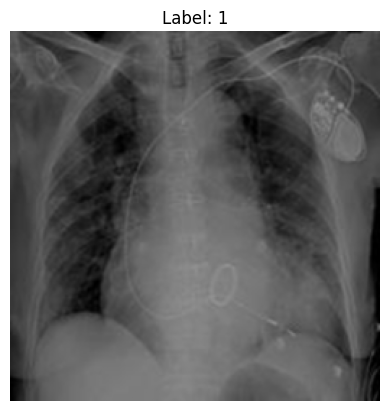

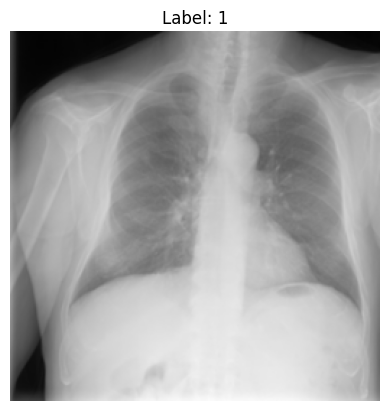

In [12]:
# Function to display one or more images from the dataset
def display_image_from_dataset(dataset):
    for images, labels in dataset.take(1):  # Take one batch
        for i in range(min(5, len(images))):  # Display up to 5 images
            plt.imshow(images[i].numpy())  # Convert tensor to NumPy array for display
            plt.title(f"Label: {labels[i].numpy()}")
            plt.axis('off')
            plt.show()

# Call the function to display images
display_image_from_dataset(main_dataset)

#Config JSON

In [13]:
CONFIGURATION = {
    "BATCH_SIZE": 16,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["COVID", "NORMAL"],
}

# Things needed to build most of the models

In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)

# ResNet50 but no fully-connected layer

In [15]:
base_model= ResNet50(include_top=False,
                     weights='imagenet',
                     input_shape=(256,256,3),
                     classifier_activation='softmax',
                     classes=2,
                     )

x=base_model.output
x=GlobalAveragePooling2D()(x)
output=Dense(1,activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 23,536,641 (89.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [16]:
# Define the optimizer
adam_opt = Adam(learning_rate=0.001)

# Compile the model for binary classification
model.compile(optimizer=adam_opt,
              loss='binary_crossentropy',  # Use binary cross-entropy for binary classification
              metrics=['accuracy'])



# Model fit

In [17]:
history = model.fit(train_dataset, epochs=5)

Epoch 1/5
604/604 ━━━━━━━━━━━━━━━━━━━━ 172s 179ms/step - accuracy: 0.9881 - loss: 0.0474
Epoch 2/5
604/604 ━━━━━━━━━━━━━━━━━━━━ 108s 179ms/step - accuracy: 0.9503 - loss: 0.5969
Epoch 3/5
604/604 ━━━━━━━━━━━━━━━━━━━━ 141s 178ms/step - accuracy: 0.9022 - loss: 0.6890
Epoch 4/5
604/604 ━━━━━━━━━━━━━━━━━━━━ 109s 180ms/step - accuracy: 0.8616 - loss: 0.5643
Epoch 5/5
604/604 ━━━━━━━━━━━━━━━━━━━━ 109s 180ms/step - accuracy: 0.8911 - loss: 0.5180


# Model test

In [18]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


130/130 ━━━━━━━━━━━━━━━━━━━━ 51s 60ms/step - accuracy: 1.0000 - loss: 0.0012
Test Loss: 0.0007631619810126722
Test Accuracy: 1.0


# Performance Matrices

In [22]:
# Evaluate on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


130/130 ━━━━━━━━━━━━━━━━━━━━ 35s 60ms/step - accuracy: 1.0000 - loss: 0.0012
Test Accuracy: 100.00%


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
true_labels = []
predicted_labels = []

# Iterate through the test dataset to collect predictions and true labels
for images, labels in test_dataset:
    predictions = model.predict(images)
    predicted_labels_batch = (predictions > 0.5).astype(int).flatten()  # For binary classification
    # predicted_labels_batch = np.argmax(predictions, axis=1)  # For multi-class classification

    true_labels.extend(labels.numpy())  # Append true labels
    predicted_labels.extend(predicted_labels_batch)  # Append predicted labels

# Convert lists to numpy arrays for metric computation
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculate performance metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

# Print the classification report
print("Classification Report:\n", classification_report(true_labels, predicted_labels))

# Print individual metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


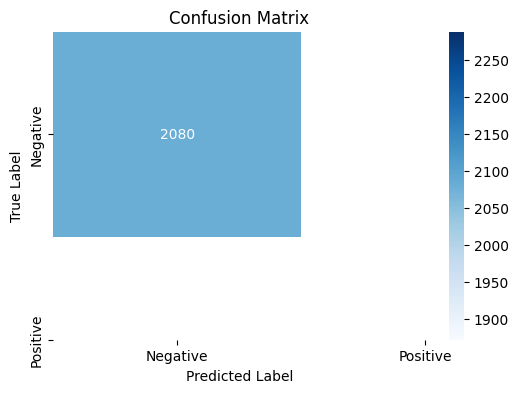

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get true labels and predicted labels from the test dataset
true_labels = []
predicted_labels = []

# Iterate through the test dataset to collect predictions and true labels
for images, labels in test_dataset:
    predictions = model.predict(images)
    predicted_labels_batch = (predictions > 0.5).astype(int).flatten()  # For binary classification
    # predicted_labels_batch = np.argmax(predictions, axis=1)  # For multi-class classification

    true_labels.extend(labels.numpy())  # Append true labels
    predicted_labels.extend(predicted_labels_batch)  # Append predicted labels

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])  # Modify labels based on your class names
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
